In [1]:
%%HTML
<style> code {background-color : pink !important;} </style>

Camera Calibration with OpenCV
===

### The cell below will extract object points and image points for camera calibration.  

In [2]:

import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
import numpy as np

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(50)

### We now have objpoints and imgpoints needed for camera calibration.  
The cell below calibrates, calculates distortion coefficients, and tests undistortion on an image!

Text(0.5,1,'Undistorted Image')

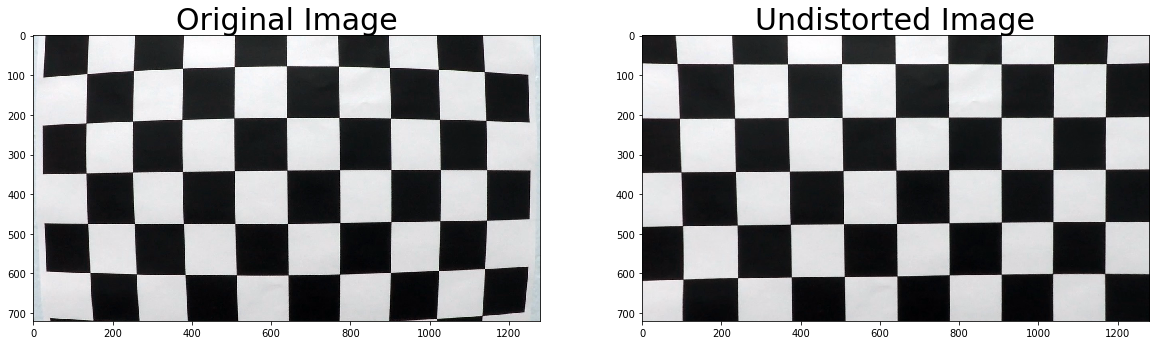

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image

img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open("camera_cal/calibrated1.p", "wb") )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Apply distortion correction on test images

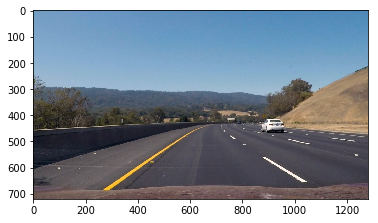

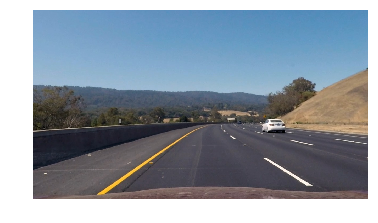

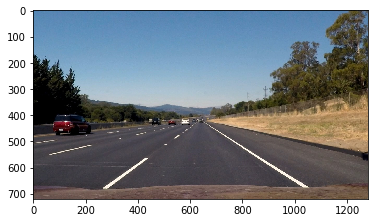

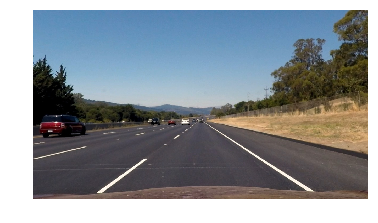

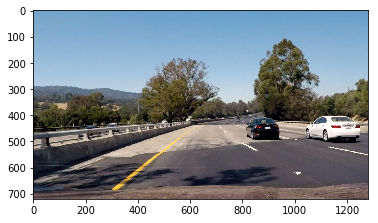

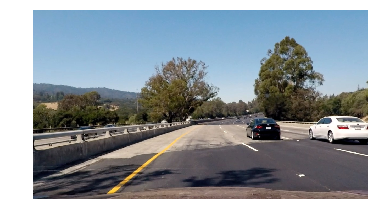

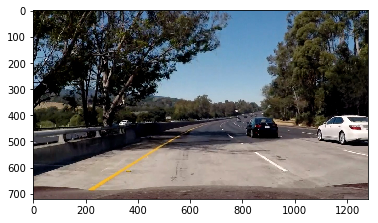

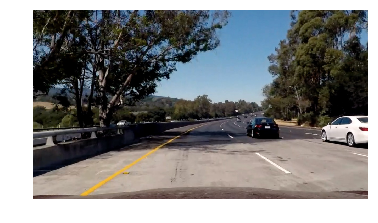

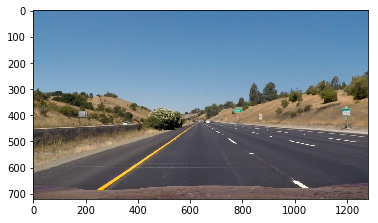

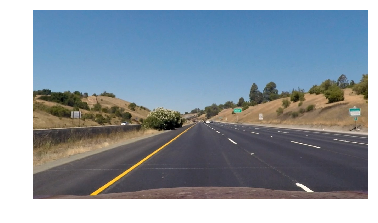

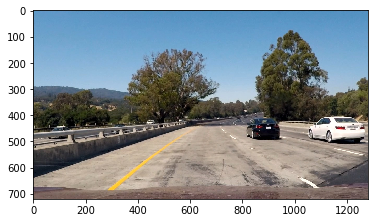

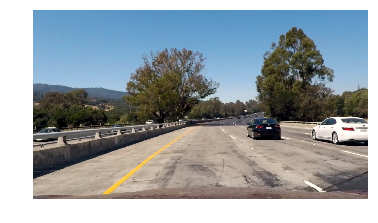

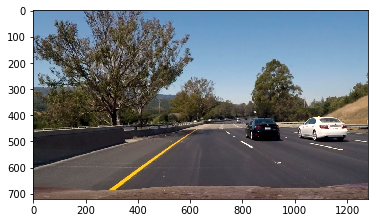

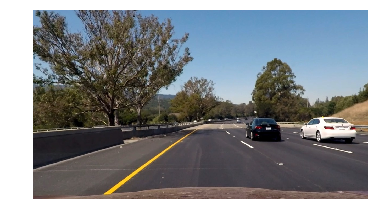

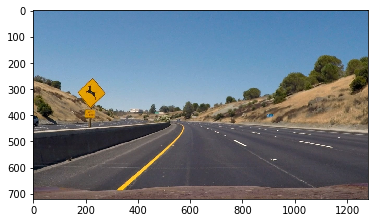

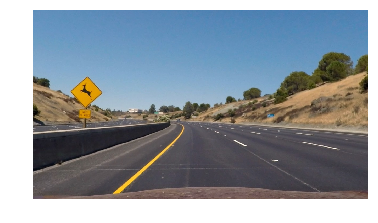

In [37]:
import os
import matplotlib.image as mpimg

test_images_path = 'test_images/'
output_images_path = 'output_images/'
test_images = os.listdir(test_images_path)
test_set = []

for image in test_images:
    img = mpimg.imread(test_images_path+image)
    
    plt.imshow(img)
    plt.show()
    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    plt.imshow(dst)
    plt.axis('off')
    plt.savefig(output_images_path+image, dpi = 400)
    plt.show()


### Apply gradient threholds

Magnitude threshold function

In [38]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)

    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely)

    mag = np.sqrt(abs_sobelx*abs_sobelx + abs_sobely*abs_sobely)
    scaled_mag = np.uint8(255 * mag / np.max(mag))

    binary = np.zeros_like(scaled_mag)
    binary[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1

    return binary

### Apply gradient threholds

Direction threshold function

In [39]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)

    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely)

    dir = np.arctan2(abs_sobely, abs_sobelx)
    binary = np.zeros_like(dir)
    binary[(dir > thresh[0]) & (dir < thresh[1])] = 1

    return binary

### Visualize a test image with direction and magnitude thresholds

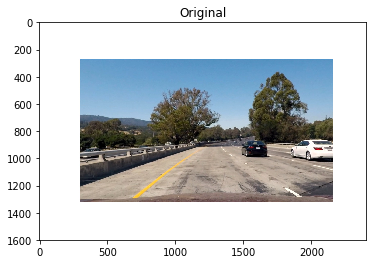

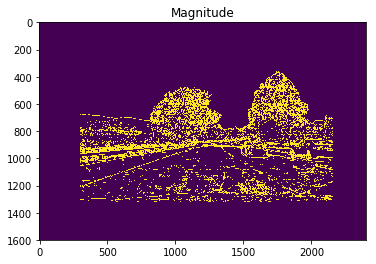

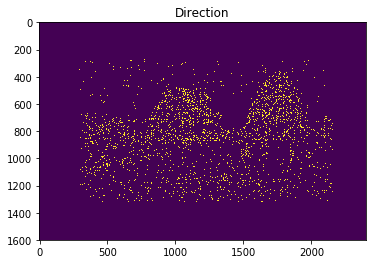

In [40]:
# load image
img = mpimg.imread(output_images_path+'test1.jpg')
plt.gca().set_title('Original')
plt.imshow(img)
plt.show()

# convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# find the magnitude of the gradient
mag = mag_thresh(gray, sobel_kernel = 3, mag_thresh = (10, 100))
plt.gca().set_title('Magnitude')
plt.imshow(mag)
plt.show()

# find the direction of the gradient and apply threshold
dir = dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/16))
plt.gca().set_title('Direction')
plt.imshow(dir)

plt.show()